In [1]:
import numpy as np
import pandas as pd
# %matplotlib notebook
import pickle
import os
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

file1 = './data/mRisk/mRisk_lapse_final.csv'
if os.path.isfile(file1) == True:
    puff_data = pd.read_csv(file1)
from sklearn import metrics
def f1Bias_scorer_CV(probs, y, ret_bias=True):
    precision, recall, thresholds = metrics.precision_recall_curve(y, probs)

    f1,bias = 0.0,.5
    min_recall = .5
    for i in range(0, len(thresholds)):
        if not (precision[i] == 0 and recall[i] == 0) and recall[i]>min_recall:
            f = 2 * (precision[i] * recall[i]) / (precision[i] + recall[i])
            if f > f1:
                f1 = f
                bias = thresholds[i]

    if ret_bias:
        return f1, bias
    else:
        return f1


def maintain_order(x,increase=True):
    for i,a in enumerate(x):
        if i==0:
            continue
        if increase:
            if x[i]<x[i-1]:
                x[i] = x[i-1]
        else:
            if x[i]>x[i-1]:
                x[i] = x[i-1]
    return x

def smooth_result(result1,window=7,polynomial=2):
    result = result1.copy()
    min_ = result[:,1].min()
    max_ = result[:,1].max()
    result[:,1] = savgol_filter(result[:,1],window , polynomial)
    result[:,1] = maintain_order(result[:,1],True)
    result[result[:,1]>max_,1] = max_
    result[result[:,1]<min_,1] = min_    
    result[:,2] = savgol_filter(result[:,2],window , polynomial)
    result[:,2] = maintain_order(result[:,2],False)
    return result

def get_smoothed_result(final_intpday,final_recall,final_gap):
    result = np.array(list(zip(final_intpday,final_recall,final_gap)))
    result = result[result[:,0].argsort()]
    result1 = result[result[:,0]<=11]
    result_final = smooth_result(result1)
    return result_final

def get_interpolated_data(result_final,x,name='Overall',iteration=1):
    result_final = result_final[result_final[:,0].argsort()]
    # print(result_final.shape)
    # print(result_final[:,1].max()>1)
    f = interp1d(result_final[:,0],result_final[:,1],fill_value=(result_final[0,1],result_final[-1,1]),bounds_error=False)
    y_recall = f(x)
    f = interp1d(result_final[:,0],result_final[:,2],fill_value=(result_final[0,2],result_final[-1,2]),bounds_error=False)
    y_gap = f(x)
    return [list(a)+[name,iteration] for a in np.array(list(zip(x,y_recall,y_gap)))]
    

# bias=f1Bias_scorer_CV(y_pred,y_test)[1]
# # bias = .1
time_gap_delta = 20
gap_th = 70

inc = ['3002', '3004', '3005', '3006', '3007', '3009', '3013', '3014', '3015', '3022', '3024', '3025', '3029', '3031', '3033',
 '3036', '3038', '3041', '3045', '3048', '3050', '3053', '3076', '3077', '3079', '3086', '3088', '3091', '3095', '3099',
 '3101', '3102', '3122', '3125', '3126', '3128', '3133', '3135', '3137', '3138', '3139', '3143', '3145', '3148', '3152',
 '3153', '3158', '3160', '3164', '3165', '3166', '3168']

n_lag = 15

data_eval = pickle.load(open('./data/output/episode_encoded_lag_15_episode_model_v9_new_validation_set_include_smoking_focal_loss_static_coeff_phenotype_lower_model_v2.p','rb'))

data_feature_label = pickle.load(open('./data/episode_encoded_lagged_data/episode_encoded_lagged_15_windows_standardized_phenotype.p','rb'))

data_cluster = pickle.load(open('./data/episode_encoded_lagged_data/episode_encoded_lagged_'+str(n_lag)+'_windows_standardized_phenotype.p','rb'))

temp = data_cluster.groupby(['user','cluster_label']).count().index.values
users = np.array([a[0] for a in temp])
labels = np.array([a[1] for a in temp])
cluster_dict = {}
for i,a in enumerate(users):
    cluster_dict[a] = labels[i]

result_phenotypes_final = {}
for label in cluster_dict.values():
    result_phenotypes_final[label] = [0,0,0,len(users[labels==label]),[],[],[],[]]
y_time = data_eval[0]
y_pred = np.array(data_eval[1])
y_test = data_eval[2]
y_pid = data_eval[3]
bias_dict = data_eval[4]
val_results = data_eval[5]
y_time = np.array(y_time)
y_pred = np.array(y_pred)
y_test = np.array(y_test)
y_pid = np.array(y_pid)
pars = np.unique(y_pid)
total_lapsers = len(pars)
indexes_pred = np.arange(y_pred.shape[1])
n_iters = 1

# for iteration in np.arange(n_iters):
def get_results(iteration):
    n_sample = 50
    x = np.arange(3.5,12.5,1)
    all_data = []
    pred_index = np.random.choice(indexes_pred,n_sample,replace=False)
    final_intpday = []
    final_recall = []
    final_gap = []
    result_phenotypes = result_phenotypes_final.copy()
    for timescap in range(10,60,4):
        part_days = 0
        total_ipd = 0
        lapse_captured = 0
        gap_s = []
        for key in result_phenotypes.keys():
            result_phenotypes[key][0] = 0
            result_phenotypes[key][1] = 0
            result_phenotypes[key][2] = 0
            result_phenotypes[key][4] = []
        for i,par in enumerate(pars):
            val_pred = val_results[bias_dict[par]][1]
            val_y = val_results[bias_dict[par]][2]
            val_time = val_results[bias_dict[par]][0]
            val_pred = val_pred[val_time.argsort()]
            val_pred = val_pred[:,pred_index].mean(axis=1)
            val_y = val_y[val_time.argsort()]
            val_time = np.array(sorted(val_time))
            df = pd.DataFrame({'time':val_time,'prob':val_pred})
            val_pred = df['prob'].rolling(window=10).mean().fillna(0).values
            # bias = f1Bias_scorer_CV(val_pred,val_y)[1]
            # bias = bias_col[int(bias_dict[par])]
            # bias = .1
            # bias = np.percentile(val_pred,71)
            a = np.where(y_pid==par)
            lapse_time = puff_data[puff_data['Participant']==int(par)]['Lapse'].values
            lapse_time = int(lapse_time[0])
            lapse_time = np.datetime64(lapse_time, 'ms') - np.timedelta64(5, 'h')
            y_pred_pid = np.median(y_pred[a][:,pred_index],axis=1)
            y_test_pid = y_test[a]
            y_time_pid = y_time[a]
            y_time_pid = np.array([y+np.timedelta64(time_gap_delta, 'm') for y in y_time_pid])
            y_pred_pid = y_pred_pid[y_time_pid.argsort()]
            y_test_pid = y_test_pid[y_time_pid.argsort()]
            y_time_pid = np.array(sorted(y_time_pid))
            df = pd.DataFrame({'time':y_time_pid,'prob':y_pred_pid})
            y_pred_pid = df['prob'].rolling(window=10).mean().fillna(0).values
            f1,bias=f1Bias_scorer_CV(y_pred_pid,y_test_pid)
            # bias = np.percentile(y_pred_pid,75)
            # print(f1,bias)
            b = (np.where(y_test_pid>0))
            y_time_lapses = y_time_pid[b]
            udays = len(np.unique(data_feature_label[data_feature_label['user']==par]['day'].values))

            part_days+=udays
            # print(result_phenotypes[cluster_dict[par]][0])
            result_phenotypes[cluster_dict[par]][0]+=udays
            

            ipd = 0
            int_given = False
            int_times = []
            for p,ys in enumerate(y_pred_pid):
                if ys>=bias:
                    if int_given==False:
                        ipd+=1
                        int_time= y_time_pid[p]
                        prev_time = int_time
                        int_times.append(int_time)
                        int_given=True
                    else:
                        timedelta = y_time_pid[p] - prev_time
                        mins = timedelta.astype('timedelta64[m]').astype(np.int32)
                        if mins>timescap and ys>=bias:
                            ipd+=1
                            int_time= y_time_pid[p]
                            int_times.append(int_time)
                            prev_time = int_time
            # try:
            # if len(set(int_times).intersection(set(y_time_lapses)))>0:
            if len(int_times)>0 and len(np.intersect1d(int_times, y_time_lapses))>1:
                gap_lapse_ = lapse_time - int_times[-1]
                gap_lapse_ = gap_lapse_.astype('timedelta64[m]').astype(np.int32)
                if gap_lapse_<gap_th:
                    lapse_captured+=1
                    result_phenotypes[cluster_dict[par]][2]+=1
            # elif int_times[-1]>=lapse_time:
            #     lapse_captured+=1
            total_ipd+=ipd
            result_phenotypes[cluster_dict[par]][1]+=ipd
            if len(int_times)>0:
                gap_lapse = lapse_time - int_times[-1]
                gap_lapse = gap_lapse.astype('timedelta64[m]').astype(np.int32)
                gap_s.append(abs(gap_lapse))
                result_phenotypes[cluster_dict[par]][4].append(abs(gap_lapse))
        # except:
        #     pass
    # print(len(gap_s))
        # print(float(lapse_captured)/total_lapsers)
        final_day_th = float(total_ipd)/part_days
        final_intpday.append(final_day_th)
        final_gap.append(np.mean(gap_s))
        final_recall.append(float(lapse_captured)/total_lapsers)

        for key in result_phenotypes.keys():
            # print(result_phenotypes[key][:4])
            
            average_int = float(result_phenotypes[key][1])/result_phenotypes[key][0]
            captured_lapse = float(result_phenotypes[key][2])/result_phenotypes[key][3]
            # print(captured_lapse>1)
            mean_gap = np.mean(result_phenotypes[key][4])
            result_phenotypes[key][5].append(average_int)
            result_phenotypes[key][6].append(captured_lapse)
            result_phenotypes[key][7].append(mean_gap)
        # print(result_phenotypes[key][5:])
    result_final = get_smoothed_result(final_intpday,final_recall,final_gap)
    result_final = get_interpolated_data(result_final,x,name='Overall',iteration=iteration)
    all_data.extend(result_final)
    for key in result_phenotypes.keys():
        result_this_cluster = get_smoothed_result(result_phenotypes[key][5],
                                                        result_phenotypes[key][6],
                                                        result_phenotypes[key][7])
        result_final_cluster = get_interpolated_data(result_this_cluster,x,name='Cluster {}'.format(key),iteration=iteration)
        all_data.extend(result_final_cluster)
    return all_data
    # print('-'*20)
from joblib import Parallel,delayed
all_data_v1 = Parallel(n_jobs=-1,verbose=2)(delayed(get_results)(iteration) for iteration in np.arange(n_iters))
all_data = []
for a in all_data_v1:
    all_data.extend(a)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   11.9s finished


In [2]:
df_predictions = pd.DataFrame({'risk':y_pred.mean(axis=1),'cluster':[cluster_dict[a] for a in y_pid],'time':y_time}) 

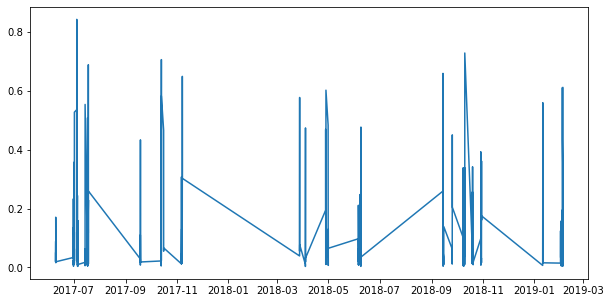

In [4]:
# plt.close('all')
# %matplotlib inline
plt.figure(figsize=(10,5))
# sns.kdeplot(x='risk',hue='cluster',data=df_predictions,common_norm=True)
# plt.hist(df_predictions[df_predictions.cluster==0]['risk'],300)
# plt.hist(df_predictions[df_predictions.cluster==1]['risk'],300)
# plt.hist(df_predictions[df_predictions.cluster==2]['risk'],300)
# plt.hist(df_predictions[df_predictions.cluster==3]['risk'],300)
plt.plot(df_predictions[df_predictions.cluster==0]['time'],df_predictions[df_predictions.cluster==0]['risk'])
plt.show()

In [231]:
df = pd.DataFrame(all_data,columns=['Interventions per day','IHR','TPI','Subtype','Iteration'])
df['Encoding'] = ['Proposed Episode Encoding']*df.shape[0]

In [232]:
df[df.Subtype=='Overall'].groupby(['Subtype','Interventions per day','Encoding'],as_index=False).mean()

,Subtype,Interventions per day,Encoding,IHR,TPI,Iteration
0,Overall,3.5,Proposed Episode Encoding,0.181139,38.253968,0
1,Overall,4.5,Proposed Episode Encoding,0.366607,31.156693,0
2,Overall,5.5,Proposed Episode Encoding,0.639333,27.151444,0
3,Overall,6.5,Proposed Episode Encoding,0.798801,23.394958,0
4,Overall,7.5,Proposed Episode Encoding,0.869790,21.231474,0
5,Overall,8.5,Proposed Episode Encoding,0.901850,19.721510,0
6,Overall,9.5,Proposed Episode Encoding,0.914566,18.761905,0
7,Overall,10.5,Proposed Episode Encoding,0.914566,18.761905,0
8,Overall,11.5,Proposed Episode Encoding,0.914566,18.761905,0


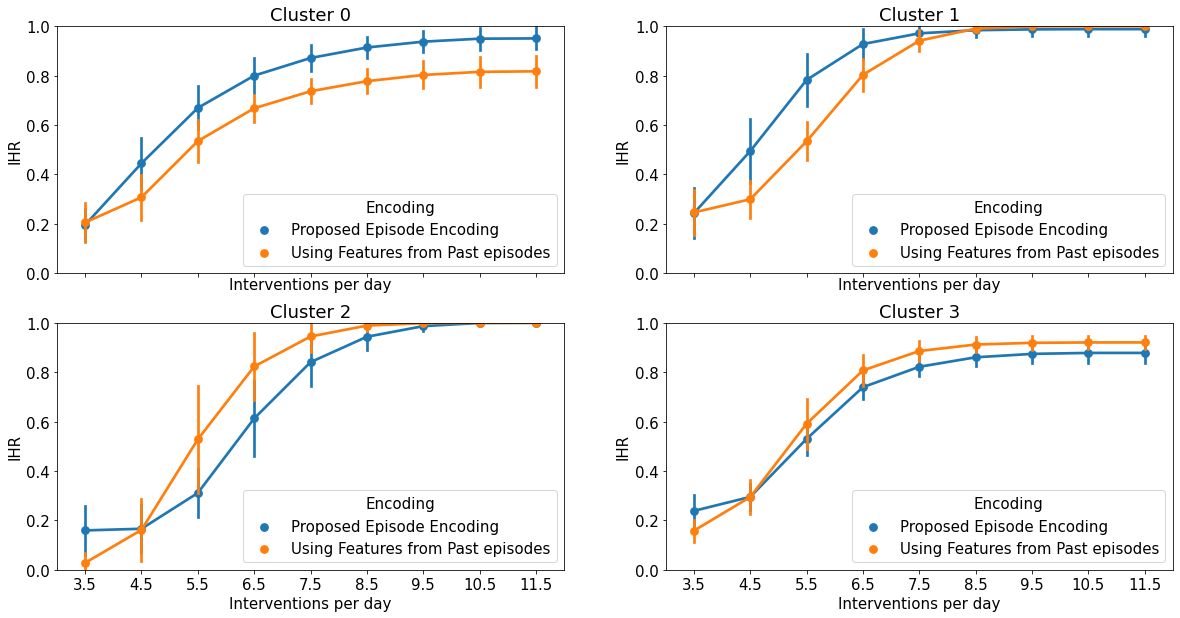

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
df  = pickle.load(open('./data/saved_result/ihr_tpi_dataframe.p','rb'))
plt.rcParams.update({'font.size':15})
fig,ax = plt.subplots(2,2,figsize=(20,10),sharex=True)
sns.pointplot(x='Interventions per day',y='IHR',hue='Encoding',data=df[df.Subtype.isin(['Cluster 0'])],ci='sd',ax=ax[0,0])
ax[0,0].set_ylim([0,1])
ax[0,0].set_title('Cluster 0')
sns.pointplot(x='Interventions per day',y='IHR',hue='Encoding',data=df[df.Subtype.isin(['Cluster 1'])],ci='sd',ax=ax[0,1])
ax[0,1].set_ylim([0,1])
ax[0,1].set_title('Cluster 1')
sns.pointplot(x='Interventions per day',y='IHR',hue='Encoding',data=df[df.Subtype.isin(['Cluster 2'])],ci='sd',ax=ax[1,0])
ax[1,0].set_ylim([0,1])
ax[1,0].set_title('Cluster 2')
sns.pointplot(x='Interventions per day',y='IHR',hue='Encoding',data=df[df.Subtype.isin(['Cluster 3'])],ci='sd',ax=ax[1,1])
ax[1,1].set_ylim([0,1])
ax[1,1].set_title('Cluster 3')

# plt.show()
# plt.figure(figsize=(20,10))
# sns.pointplot(x='Interventions per day',y='TPI',hue='Subtype',data=df[df.Encoding.isin(['Proposed Episode Encoding']) & ~df.Subtype.isin(['Overall'])],ci='sd',ax=ax[1])
# plt.tight_layout()
# plt.savefig('./data/images/cluster_performance.png')
plt.show()

In [8]:
# df1 = df.copy()
# from collections import Counter
# Counter(cluster_dict.values())
df.Subtype.unique()

array(['Overall', 'Cluster 3', 'Cluster 1', 'Cluster 2', 'Cluster 0'],
      dtype=object)

In [153]:
df1['Encoding'] = ['Proposed Episode Encoding']*df.shape[0]

In [159]:
df2 = df.copy()

In [160]:
df2['Encoding'] = ['Using Features from Past episodes']*df.shape[0]

In [161]:
df = pd.concat([df1,df2])

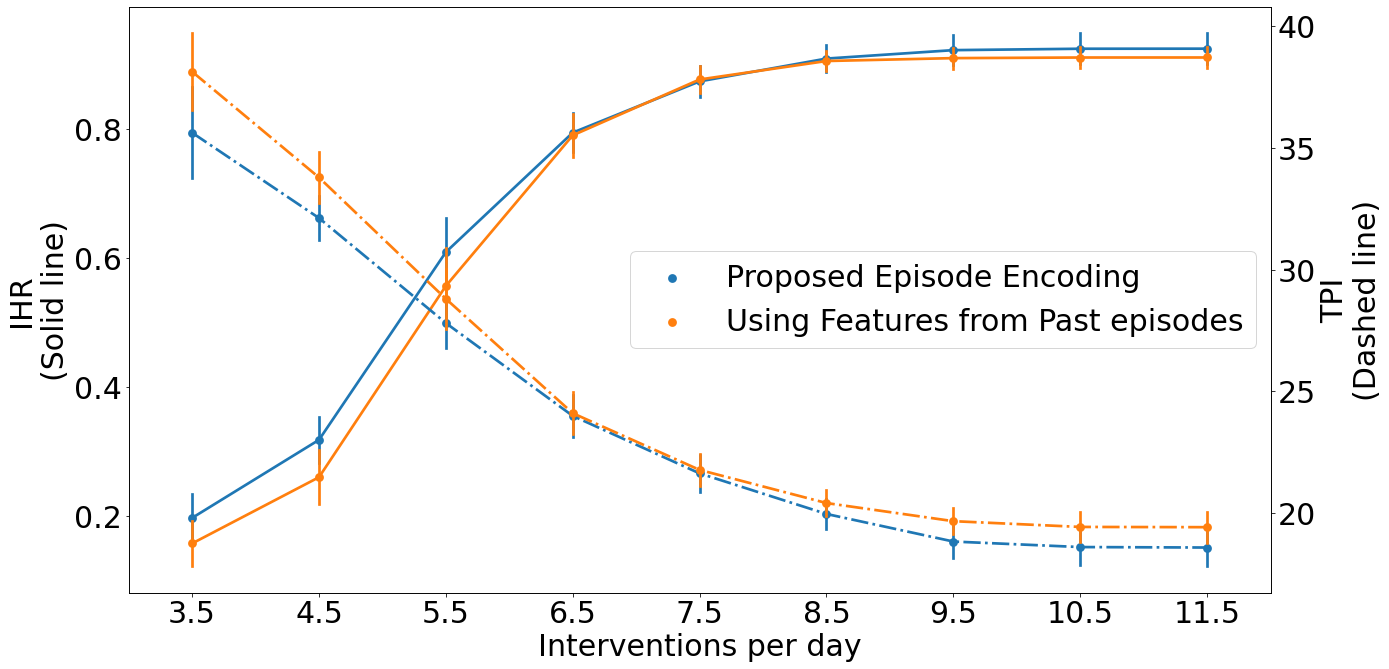

In [180]:
plt.rcParams.update({'font.size':30})
fig,ax = plt.subplots(1,1,figsize=(20,10))
sns.pointplot(x='Interventions per day',y='IHR',hue='Encoding',data=df[df.Subtype=='Overall'],ci='sd')
ax.set_ylabel('IHR\n(Solid line)')
plt.legend(loc='center right')
ax1 = ax.twinx()
g = sns.pointplot(x='Interventions per day',y='TPI',hue='Encoding',data=df[df.Subtype=='Overall'],ci='sd',ax=ax1,linestyles='-.')
ax1.set_ylabel('TPI\n(Dashed line)')

# ax1._remove_legend()
plt.legend([],[], frameon=False)
plt.tight_layout()
plt.savefig('./data/images/encoding_type.png')

In [181]:
pickle.dump(df,open('./data/saved_result/ihr_tpi_dataframe.p','wb'))

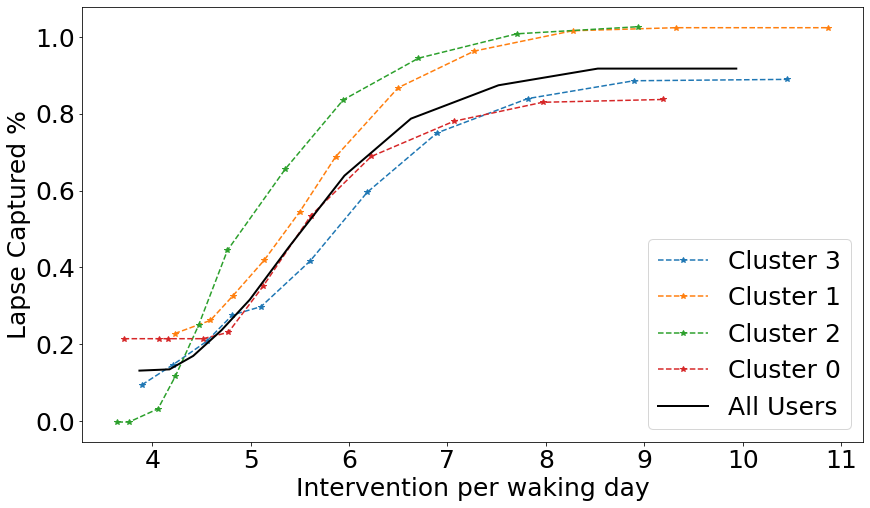

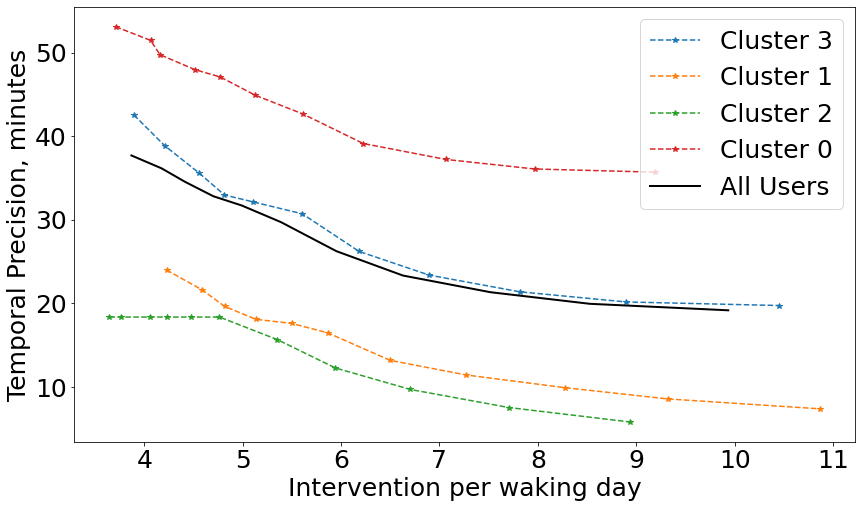

array([[ 3.87037037,  0.13118581, 37.68253968],
       [ 4.17592593,  0.13445378, 36.14565826],
       [ 4.41666667,  0.16946779, 34.51820728],
       [ 4.7037037 ,  0.23622782, 32.80018674],
       [ 4.99074074,  0.3155929 , 31.70028011],
       [ 5.38888889,  0.45284781, 29.71148459],
       [ 5.9537037 ,  0.63865546, 26.22875817],
       [ 6.62962963,  0.78711485, 23.3155929 ],
       [ 7.51851852,  0.87394958, 21.32212885],
       [ 8.52777778,  0.91736695, 19.93557423],
       [ 9.93518519,  0.91736695, 19.15592904]])

In [58]:
plt.figure(figsize=(14,8))
for key in result_phenotypes_final.keys():
    plt.plot(result_phenotypes_final[key][:,0],result_phenotypes_final[key][:,1],'--*',label='Cluster {}'.format(key))
plt.plot(result_final[:,0],result_final[:,1],linewidth=2,c='k',label='All Users')
plt.ylabel('Lapse Captured %')
plt.xlabel('Intervention per waking day')
plt.legend()
plt.show()
plt.figure(figsize=(14,8))
for key in result_phenotypes_final.keys():
    plt.plot(result_phenotypes_final[key][:,0],result_phenotypes_final[key][:,2],'--*',label='Cluster {}'.format(key))
plt.plot(result_final[:,0],result_final[:,2],linewidth=2,c='k',label='All Users')
plt.ylabel('Temporal Precision, minutes')
plt.xlabel('Intervention per waking day')
plt.legend()
plt.show()
result_final


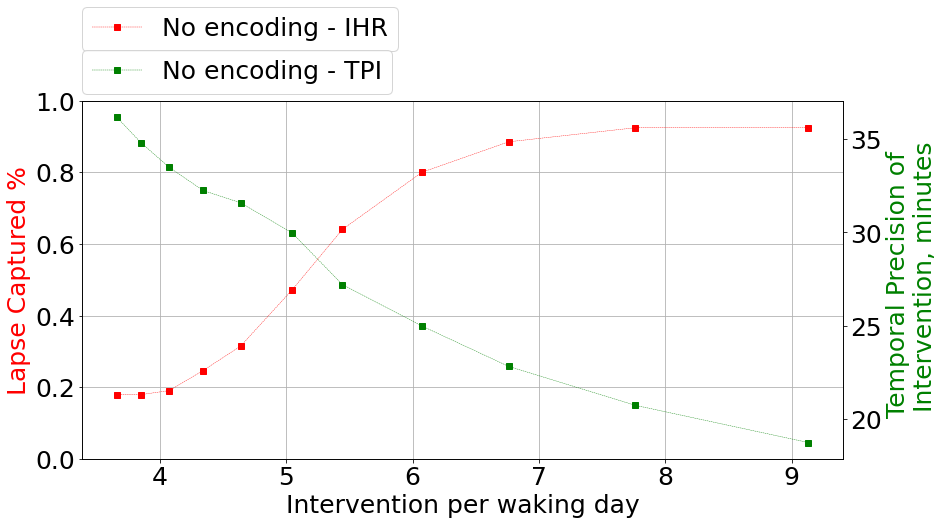

In [54]:
# pprint(result_final)

plt.rcParams.update({'font.size':25})
plt.figure(figsize=(14,8))
plt.plot(result_final[:,0],result_final[:,1],c='r',linewidth=.4,linestyle='--',marker='s',label='No encoding - IHR')
# plt.plot(result_episode[:,0],result_episode[:,1],c='r',linewidth=1,linestyle='--',marker='d',label='Episode encoding - IHR')
plt.legend(loc=(0,1.14),ncol=2)
plt.grid()
ax = plt.gca()
ax2 = ax.twinx()
ax2.plot(result_final[:,0],result_final[:,2],c='g',marker='s',linestyle='--',linewidth=.4,label='No encoding - TPI')
# ax2.plot(result_episode[:,0],result_episode[:,2],c='g',marker='d',linewidth=1,linestyle='--',label='Episode encoding - TPI')
plt.legend(loc=(0,1.02),ncol=2)
ax2.set_ylabel('Temporal Precision of \n Intervention, minutes',c='g')
ax.set_ylabel('Lapse Captured %',c='r')
ax.set_xlabel('Intervention per waking day')
# ax.set_yticks(c='r')
plt.tight_layout()
ax.set_ylim([0,1])
plt.show()


In [646]:
result_episode = result_final.copy()
# result_final

In [619]:
# pickle.dump([result_final,result_episode],open('./data/saved_result/ihr_tpi.p','wb'))

0.8823529411764706
[(16.925925925925927, 0.9607843137254902, 0.9547152194211014),
 (12.925925925925926, 0.9607843137254902, 0.9495798319327728),
 (10.601851851851851, 0.9019607843137255, 0.9313725490196076),
 (8.907407407407407, 0.8823529411764706, 0.9000933706816067),
 (7.87962962962963, 0.8823529411764706, 0.8636788048552761),
 (6.944444444444445, 0.8235294117647058, 0.8188608776844079),
 (6.25, 0.7058823529411765, 0.6993464052287588),
 (5.7592592592592595, 0.5882352941176471, 0.551820728291317),
 (5.268518518518518, 0.35294117647058826, 0.41549953314659244),
 (4.953703703703703, 0.3333333333333333, 0.3370681605975727),
 (4.657407407407407, 0.29411764705882354, 0.27871148459383766),
 (4.416666666666667, 0.3137254901960784, 0.25210084033613456),
 (4.194444444444445, 0.21568627450980393, 0.25723622782446326)]


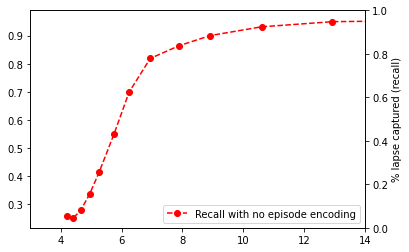

In [450]:

final_recall = np.array(final_recall)
final_intpday = np.array(final_recall)
final_recall1 = savgol_filter(final_recall,7 , 2) # window size 13, polynomial order 5
final_gap1 = savgol_filter(final_gap,7 , 2)
previous = savgol_filter(aaa[1],7,2)
print(np.median(final_recall[:9]))
from pprint import pprint

# print(final_intpday)
# print(final_gap)
import matplotlib.pyplot as plt
plt.plot(final_intpday,final_recall1,linestyle='--', marker='o', color='r',label='Recall with no episode encoding')
# plt.plot(final_intpday,final_gap,linestyle='--', marker='o', color='g',label='Precision')
# plt.plot(aaa[0],previous,linestyle='--', marker='o', color='g',label="Recall with episode encoding")
pprint(list(zip(final_intpday,final_recall,final_recall1)))
plt.legend()
ax = plt.gca()
ax2=ax.twinx()
# ax2.plot(final_intpday,final_gap1)
plt.xlabel('Interventions per day')
plt.ylabel('% lapse captured (recall)')
plt.xlim([3,14])
# plt.ylabel('Gap between ID and Lapse')
# plt.ylim(30, 80)

plt.show()



lag = 60, 45 minutes:
    Recall
    Temporal precision
    (Smooth)

phenotyping




In [421]:
aaa = [final_intpday,final_recall,final_gap]

In [9]:
smoking_cross_entropy = [final_intpday,final_recall]

In [5]:
smoking_focal = [final_intpday,final_recall]

In [ ]:
import matplotlib.pyplot as plt

plt.plot(aaa[0],aaa[1],linestyle='--', marker='o', color='r',label='LR')
plt.xlabel('Interventions per day')
# plt.ylabel('% lapse captured (recall)')
plt.ylabel('Gap between ID and Lapse')
# plt.ylim(30, 80)
plt.legend()
plt.show()

In [ ]:
aaa = [final_intpday,final_recall]